## Analysis of the workflow lifetime and their distribution in each status
This notebook is used to parse workflows from ReqMgr2 and properly understand their lifetime and time distribution according to their statuses.

In [1]:
import os
import sys
import requests
import json
import statistics
from pprint import pprint
from tabulate import tabulate

myCert = "/Users/amaltar2/Devel/DockerWMCore/certs/servicecert.pem"
myKey = "/Users/amaltar2/Devel/DockerWMCore/certs/servicekey.pem"

### Fetch workflows from ReqMgr2

In [25]:
headers = {"Content-type": "application/json", "Accept": "application/json"}
reqmgrUrl = "https://cmsweb.cern.ch/reqmgr2/data/request"
params = {"name": "cmsunified_task_PPD-Run3Winter23Digi-00030__v1_T_230609_094934_6689"}
data = requests.get(reqmgrUrl, params=params, headers=headers, cert=(myCert, myKey), verify=False)
if data.ok is True:
    data = data.json()['result']

[{'cmsunified_task_PPD-Run3Winter23Digi-00030__v1_T_230609_094934_6689': {'_id': 'cmsunified_task_PPD-Run3Winter23Digi-00030__v1_T_230609_094934_6689', 'Group': 'DATAOPS', 'Requestor': 'cmsunified', 'ProcessingString': {'PPD-Run3Winter23Digi-00030_0': 'FlatPU0to80GTv4BTag_126X_mcRun3_2023_forPU65_forBTag_v1', 'PPD-Run3Winter23Reco-00030_0': 'FlatPU0to80GTv4BTag_GTv4BTag_126X_mcRun3_2023_forPU65_forBTag_v1', 'PPD-Run3Winter23MiniAOD-00026_0': 'FlatPU0to80GTv4BTag_GTv4BTag_MiniGTv4BTag_126X_mcRun3_2023_forPU65_forBTag_v1', 'PPD-Run3Winter23NanoAOD-00026_0': 'FlatPU0to80GTv4BTag_GTv4BTag_MiniGTv4BTag_NanoGTv4BTag_126X_mcRun3_2023_forPU65_forBTag_v1'}, 'ScramArch': ['el8_amd64_gcc10'], 'SizePerEvent': 1930.782, 'Memory': 7900, 'PrepID': 'task_PPD-Run3Winter23Digi-00030', 'RequestType': 'StepChain', 'TimePerEvent': 37.3402, 'AcquisitionEra': {'PPD-Run3Winter23Digi-00030_0': 'Run3Winter23Digi', 'PPD-Run3Winter23Reco-00030_0': 'Run3Winter23Reco', 'PPD-Run3Winter23MiniAOD-00026_0': 'Run3Winter

/Users/amaltar2/.virtualenvs/py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


### OR, fetch workflows directly from CouchDB - including archived workflows

In [47]:
%%time
couchUrl = "https://cmsweb.cern.ch/couchdb/reqmgr_workload_cache/_design/ReqMgr/_view/bydate"
queryParams = {"startkey": "[2022,4,1]", "endkey": "[2023,4,1]", "include_docs": True}
data = requests.get(couchUrl, params=queryParams, headers=headers, cert=(myCert, myKey), verify=False)
print(data)
if data.ok is True:
    data = data.json()['rows']
print(f"Total number of workflows: {len(data)}")

/Users/amaltar2/.virtualenvs/py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>
Total number of workflows: 236810


### save this workflow data in a json to avoid this heavy query against CouchDB

In [48]:
with open("workflow_dump.json", "w") as fo:
    json.dump(data, fo, indent=2)

In [2]:
with open("workflow_dump.json", "r") as fo:
    data = json.load(fo)
print(f"Loaded a total of {len(data)} workflows.")

Loaded a total of 236810 workflows.


## Parse each document creating a timeline per campaign

In [8]:
%%time
normal_wfs = []
rejected_wfs = []
aborted_wfs = []
others_wfs = []
for wflow in data:
    summary = {}
    summary["RequestName"] = wflow["doc"]["RequestName"]
    summary["RequestType"] = wflow["doc"]["RequestType"]
    summary["RequestStatus"] = wflow["doc"]["RequestStatus"]
    summary["Campaign"] = wflow["doc"]["Campaign"]
    summary["StatusDuration"] = []
    summary["Wallclocktime"] = 0
    ## then parse status transition
    totalTransitions = len(wflow["doc"]["RequestTransition"])
    for idx, item in enumerate(wflow["doc"]["RequestTransition"]):
        if item["Status"] in ("normal-archived", "rejected-archived", "aborted-archived"):
            # then we are in the last transition (theoretically), grab the total workflow wallclocktime
            summary["Wallclocktime"] = item["UpdateTime"] - wflow["doc"]["RequestTransition"][0]["UpdateTime"]
        elif idx < totalTransitions - 1:
            # intermediate transitions, use the next step to calculate time duration
            thisTransition = {"Status": item["Status"]}
            thisTransition["DurationSecs"] = wflow["doc"]["RequestTransition"][idx + 1]["UpdateTime"] - item["UpdateTime"]
        summary["StatusDuration"].append(thisTransition)

    # now classify this workflow according to its current status
    if summary["RequestStatus"] == "normal-archived":
        normal_wfs.append(summary)
    elif summary["RequestStatus"] == "rejected-archived":
        rejected_wfs.append(summary)  
    elif summary["RequestStatus"] == "aborted-archived":
        aborted_wfs.append(summary)  
    else:
        others_wfs.append(summary)  

CPU times: user 1.2 s, sys: 1.38 s, total: 2.58 s
Wall time: 3.6 s


## Print number of workflows in each status

In [9]:
# while this object will contain final stats for workflows in a given status
columnNames = ["status", "num workflows"]
wflowStats = []
wflowStats.append(["normal-archived", len(normal_wfs)])
wflowStats.append(["rejected-archived", len(rejected_wfs)])
wflowStats.append(["aborted-archived", len(aborted_wfs)])
# now get numbers for the other statuses
dictStatuses = {}
for wflow in others_wfs:
    dictStatuses.setdefault(wflow["RequestStatus"], 0)
    dictStatuses[wflow["RequestStatus"]] += 1
    
for status, wflowCount in dictStatuses.items():
    wflowStats.append([status, wflowCount])

wflowStats.append(["TOTAL", len(normal_wfs) + len(rejected_wfs) + len(aborted_wfs) + len(others_wfs)])

#pprint(wflowStats)
print(tabulate(wflowStats, headers=columnNames, tablefmt="fancy_grid"))

╒═════════════════════╤═════════════════╕
│ status              │   num workflows │
╞═════════════════════╪═════════════════╡
│ normal-archived     │          152237 │
├─────────────────────┼─────────────────┤
│ rejected-archived   │           66055 │
├─────────────────────┼─────────────────┤
│ aborted-archived    │           15996 │
├─────────────────────┼─────────────────┤
│ announced           │            1719 │
├─────────────────────┼─────────────────┤
│ completed           │             239 │
├─────────────────────┼─────────────────┤
│ new                 │             370 │
├─────────────────────┼─────────────────┤
│ assignment-approved │              59 │
├─────────────────────┼─────────────────┤
│ failed              │             102 │
├─────────────────────┼─────────────────┤
│ staging             │               6 │
├─────────────────────┼─────────────────┤
│ acquired            │              11 │
├─────────────────────┼─────────────────┤
│ aborted             │           

## Get stats for archived workflows (mean, median, stddev)

In [17]:
# while this object will contain final stats for workflows in a given status
columnNames = ["status", "mean (days)", "median (days)", "stdev (days)"]
wflowStats = {}
daySecs = 24 * 3600
for wf in normal_wfs:
    wflowStats.setdefault("normal-archived", [])
    wflowStats["normal-archived"].append(wf["Wallclocktime"])
for wf in aborted_wfs:
    wflowStats.setdefault("aborted-archived", [])
    wflowStats["aborted-archived"].append(wf["Wallclocktime"])

# variable to keep the number of workflows that was rejected after running in the grid
# new -> assignment-approved -> assigned -> staging -> staged -> acquired -> running-open -> running-closed
# completed -> ?rejected
lateRejection = 0
for wf in rejected_wfs:
    wflowStats.setdefault("rejected-archived", [])
    wflowStats["rejected-archived"].append(wf["Wallclocktime"])
    if len(wf["StatusDuration"]) > 8:
        lateRejection += 1
print(f"Found a total of {lateRejection} workflows rejected after running in the grid resources")

# now calculte mean, median and std deviation
results = []
for status, values in wflowStats.items():
    thisStats = []
    thisStats.append(status)
    thisStats.append(round(statistics.mean(values) / daySecs, 2))
    thisStats.append(round(statistics.median(values) / daySecs, 2))
    thisStats.append(round(statistics.stdev(values) / daySecs, 2))
    results.append(thisStats)

#pprint(wflowStats)
print(tabulate(results, headers=columnNames, tablefmt="fancy_grid"))

Found a total of 3509 workflows rejected after running in the grid resources
╒═══════════════════╤═══════════════╤═════════════════╤════════════════╕
│ status            │   mean (days) │   median (days) │   stdev (days) │
╞═══════════════════╪═══════════════╪═════════════════╪════════════════╡
│ normal-archived   │         36.83 │           13.34 │          43.12 │
├───────────────────┼───────────────┼─────────────────┼────────────────┤
│ aborted-archived  │         11.92 │            3.32 │          21.09 │
├───────────────────┼───────────────┼─────────────────┼────────────────┤
│ rejected-archived │          6.16 │            2.75 │          16.55 │
╘═══════════════════╧═══════════════╧═════════════════╧════════════════╛


## Grab some statistics for the normal-archived workflows (mean, median, stddev)

In [21]:
ACTIVE_STATUS = ["new",
                 "assignment-approved",
                 "assigned",
                 "staging",
                 "staged",
                 "acquired",
                 "running-open",
                 "running-closed",
                 "force-complete",
                 "completed",
                 "closed-out",
                 "announced"]

# this object will contain all the absolute values for each workflow in each state
wflowValues = {}
for status in ACTIVE_STATUS:
    wflowValues[status] = []
for wflow in normal_wfs:
    for statusDict in wflow["StatusDuration"]:
        try:
            wflowValues[statusDict["Status"]].append(statusDict["DurationSecs"])
        except KeyError:
            print(f"Workflow {wflow['RequestName']} has an invalid status: {statusDict['Status']}")

Workflow pdmvserv_task_SMP-RunIISummer20UL16wmLHEGENAPV-00395__v1_T_220402_125734_9831 has an invalid status: rejected
Workflow haozturk_task_HIG-RunIISummer20UL16wmLHEGENAPV-03899__v1_T_220601_172532_7089 has an invalid status: rejected
Workflow pdmvserv_task_HIG-RunIISummer20UL16wmLHEGEN-06204__v1_T_220607_111555_5126 has an invalid status: rejected
Workflow pdmvserv_task_EXO-Run3Summer22wmLHEGS-00766__v1_T_230109_113601_2471 has an invalid status: rejected


In [22]:
# while this object will contain final stats for workflows in a given status
wflowStats = []
daySecs = 24 * 3600
for status in wflowValues:
    thisStats = []
    thisStats.append(status)
    thisStats.append(round(statistics.mean(wflowValues[status]) / daySecs, 2))
    thisStats.append(round(statistics.median(wflowValues[status]) / daySecs, 2))
    thisStats.append(round(statistics.stdev(wflowValues[status]) / daySecs, 2))
    wflowStats.append(thisStats)

columnNames = ["status", "mean (days)", "median (days)", "stdev (days)"]
print(tabulate(wflowStats, headers=columnNames, tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤═════════════════╤════════════════╕
│ status              │   mean (days) │   median (days) │   stdev (days) │
╞═════════════════════╪═══════════════╪═════════════════╪════════════════╡
│ new                 │          0.74 │            0    │           1.68 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ assignment-approved │         10.23 │            0.05 │          24.39 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ assigned            │          0.01 │            0    │           0.15 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ staging             │          0.84 │            0.03 │           3.3  │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ staged              │          0.02 │            0.01 │           0.1  │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ acquired            │  

## now make a normal distribution



In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

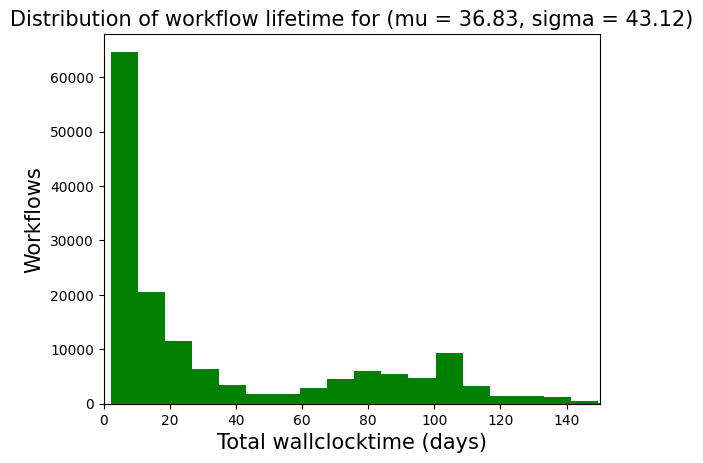

In [35]:
norm_values = [wf["Wallclocktime"] for wf in normal_wfs]
norm_values_days = [round(totalSecs / daySecs, 2) for totalSecs in norm_values]

mu_secs = round(statistics.mean(norm_values), 2)
sigma_secs = round(statistics.stdev(norm_values), 2)
mu_days = round(mu_secs / daySecs, 2)
sigma_days = round(sigma_secs / daySecs, 2)

# Creating histogram
fig, ax = plt.subplots()
ax.hist(norm_values_days, bins=50, color ='green')
plt.xlim(0, 150) 
plt.title(f'Distribution of workflow lifetime for (mu = {mu_days}, sigma = {sigma_days})', fontsize='15')
plt.xlabel('Total wallclocktime (days)', fontsize='15')
plt.ylabel('Workflows', fontsize='15')

# Show plot
plt.show()

In [49]:
zero_sigma = mu_days + (0 * sigma_days)
one_sigma = mu_days + (1 * sigma_days)
two_sigma = mu_days + (2 * sigma_days)
three_sigma = mu_days + (3 * sigma_days)

in_zero_sigma = [item for item in norm_values_days if item < zero_sigma]
in_one_sigma = [item for item in norm_values_days if item < one_sigma]
in_two_sigma = [item for item in norm_values_days if item < two_sigma]
in_three_sigma = [item for item in norm_values_days if item < three_sigma]

print(f"Rate of workflows within 0 sigma: {len(in_zero_sigma)/len(norm_values_days)}")
print(f"Rate of workflows within 1 sigma: {len(in_one_sigma)/len(norm_values_days)}")
print(f"Rate of workflows within 2 sigma: {len(in_two_sigma)/len(norm_values_days)}")
print(f"Rate of workflows within 3 sigma: {len(in_three_sigma)/len(norm_values_days)}")

Rate of workflows within 0 sigma: 0.6822191714235042
Rate of workflows within 1 sigma: 0.7943404034498841
Rate of workflows within 2 sigma: 0.9659675374580424
Rate of workflows within 3 sigma: 0.9916051945322096


## Trying a percentile plot now based on:
https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_viz.html

In [45]:
import warnings
warnings.simplefilter('ignore')
import seaborn
import probscale
clear_bkgd = {'axes.facecolor':'none', 'figure.facecolor':'none'}
seaborn.set(style='ticks', context='talk', color_codes=True, rc=clear_bkgd)

position 152237
days 152237


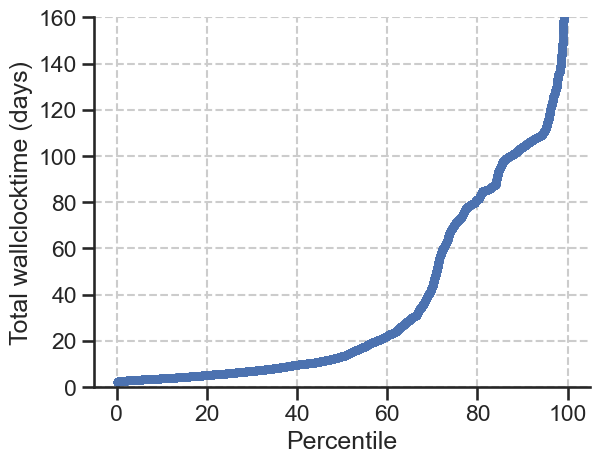

In [58]:
position, days = probscale.plot_pos(norm_values_days)
position *= 100
fig, ax = plt.subplots()
plt.grid(visible=True, which='major', axis='both', linestyle='--')
#ax.plot(position, days, marker='.', linestyle='none', label='Workflow wallclocktime')
ax.plot(position, days, marker='.', label='Workflow wallclocktime')
ax.set_xlabel('Percentile')
ax.set_ylabel('Total wallclocktime (days)')
ax.set_ylim(bottom=0, top=160)
seaborn.despine()